7/8/2019

# Across-layer prediction with Copenhagen Network Study


In [3]:
#!pip install networkx==2.2

In [4]:
from __future__ import division
import os
import re
import itertools
from datetime import datetime, timedelta
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
folder_directory =os.getcwd()
os.chdir(folder_directory)
exec(open('./functions/python_libraries.py').read())
exec(open('./functions/LINK_revised.py').read())
np.seterr(divide='ignore', invalid='ignore')
from sklearn.ensemble import BaggingClassifier # needed for logforest

import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) # scale ReFeX features

In [10]:
x_train = pd.read_csv('../../code/refex-rolx-master'+ 
                              refex_num + 
                            '/Copenhagen-data/out_union_0.5_Copenhagen_df_'+ train_subset_type +'_undirected.csv-featureValues.csv',
                             header = None)
x_train.head()

,0,1,2,3,4,5,6
0,338,0.0,2.0,1.0,1.0,1.0,2.0
1,339,0.0,2.0,1.0,2.0,1.0,2.0
2,332,0.0,1.0,1.0,1.0,1.0,1.0
3,333,0.0,3.0,1.0,2.0,1.0,3.0
4,330,0.0,4.0,1.0,4.0,1.0,3.0


## Paper Figures Across-Layer
(train on one edge type, loop through testing on other edge types)

In [11]:
train_subset_type = 'facebook_friends' #'facebook_friends' #'calls' 'bt'
test_type = ['facebook_friends', 'calls', 'bt','sms']
refex_num_array = ['-1','-2','-3','']

undersampling = False #False #True 
RF = True 
auc_record_results = []


for refex_num in refex_num_array:
    auc_record = []
    for test_subset in test_type:
        # set-up TRAIN data
        x_train = pd.read_csv('../../code/refex-rolx-master'+ 
                              refex_num + 
                            '/Copenhagen-data/out_union_0.5_Copenhagen_df_'+ train_subset_type +'_undirected.csv-featureValues.csv',
                             header = None)
        x_train.head()
        df_train = pd.DataFrame({'keys':np.array(x_train[0])})
        y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
        y_train_y.columns = ['keys','gender_y']


        ## modification: only subset to common keys where we know the gender
        ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
        x_train = x_train.iloc[np.in1d(df_train['keys'], ids_train)]
        df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


        # set-up test data
        x_test = pd.read_csv('../../code/refex-rolx-master'+ 
                             refex_num +
                             '/Copenhagen-data/out_union_0.5_Copenhagen_df_'+ test_subset +'_undirected.csv-featureValues.csv',
                             header = None)
        df_test = pd.DataFrame({'keys':np.array(x_test[0])})
        y_test_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
        y_test_y.columns = ['keys','gender_y']
        y_test_y.head()


        ids_test = np.array(df_test['keys'])[np.in1d(np.array(df_test['keys']), np.array(y_test_y['keys']))]
        x_test = x_test.iloc[np.in1d(df_test['keys'], ids_test)]
        df_test = df_test.iloc[np.in1d(df_test['keys'], ids_test)]

        x_train = x_train.loc[:,1::] #drop IDs column
        scaler.fit(x_train) #transform each feature on [0,1]-scale
        x_train = scaler.transform(x_train)


        x_test = x_test.loc[:,1::] #drop IDs column
        scaler.fit(x_test) #transform each feature on [0,1]-scale
        x_test = scaler.transform(x_test)

        x_train_names = pd.read_csv('../../code/refex-rolx-master'+refex_num+'/Copenhagen-data/union_unique_featureNames.csv')
        x_test_names = pd.read_csv('../../code/refex-rolx-master'+refex_num+'/Copenhagen-data/union_unique_featureNames.csv')



        y_train = df_train.merge(y_train_y[['keys','gender_y']],
                how = 'left',
                on = 'keys')
        print(np.sum(y_train.gender_y.isna()))
        print(np.sum(y_train.gender_y.isnull()))
        y_test = df_test.merge(y_test_y[['keys','gender_y']],
            how = 'left',
            on = 'keys')
        print(np.sum(y_test.gender_y.isna()))
        print(np.sum(y_test.gender_y.isnull()))
        x_train_m = pd.DataFrame(np.matrix(x_train)[:,np.array(range(len(x_train_names.columns)))[np.in1d(np.array(x_train_names.columns), 
                                                                                         np.array(x_test_names.columns))]])
        x_test_m = pd.DataFrame(np.matrix(x_test)[:,np.array(range(len(x_test_names.columns)))[np.in1d(np.array(x_test_names.columns), 
                                                                                          np.array(x_train_names.columns))]])

        x_train_m.columns = np.array(x_train_names.columns)[np.in1d(np.array(x_train_names.columns), 
                                                        np.array(x_test_names.columns))]
        x_test_m.columns = np.array(x_test_names.columns)[np.in1d(np.array(x_test_names.columns), 
                                                        np.array(x_train_names.columns))]

        ## sort to be same
        arg_sort_idx = np.array(x_train_m.columns).argsort()
        x_train_m = x_train_m.iloc[:,arg_sort_idx]
        x_test_m = x_test_m.iloc[:,arg_sort_idx]

        num_features = np.shape(x_train_m)[1]
        print('num of features: ', np.int(np.round(np.log(num_features)))+1)


        if undersampling:
            if RF:
                max_depth = [3, 5, 10]
                max_depth.append(None)
                min_samples_leaf = [0.05, 0.1, 0.2]
                min_samples_split = [2, 3, 4, 5, 10]
                n_estimators = [50, 100, 150] #[10, 50, 100, 150, 200]
                max_features = ['auto', 0.25, 0.5, 0.75]
                random_grid = {'clf__max_depth': max_depth,
                             'clf__min_samples_leaf': min_samples_leaf,
                             'clf__max_features': max_features,
                              'clf__n_estimators': n_estimators,
                              'clf__min_samples_split': min_samples_split
                }

                clf = sklearn.ensemble.RandomForestClassifier()
                pipeline = imbPipeline([('undersample', imblearn.under_sampling.RandomUnderSampler(random_state=567)),
                                            #('oversample',imblearn.over_sampling.SMOTE()), 
                                    ('clf',clf)])
                model = RandomizedSearchCV(estimator = pipeline,
                        param_distributions = random_grid,
                        cv = 3, verbose=0,
                        n_jobs = 2)

            else:
                clf = BaggingClassifier(linear_model.LogisticRegression(penalty='l2',
                    solver='lbfgs',
                    C=10e20),
                    n_estimators=500,
                    max_features=np.int(np.round(np.log(num_features)))+1)
                model = imbPipeline([('undersample', imblearn.under_sampling.RandomUnderSampler()),
                    #('oversample',imblearn.over_sampling.SMOTE()),
                     ('clf',clf)])

        else:
            if RF:
                # testing only increasing _leaf and _split to 5
                max_depth = [3, 5, 10]
                max_depth.append(None)
                min_samples_leaf = [1, 5]#[0.05, 0.1, 0.2]
                min_samples_split = [2, 5] #[2, 3, 4, 5, 10]
                n_estimators = [ 100, 1000]#150]
                max_features = ['auto', 0.25, 0.5, 0.75]
                random_grid = {'max_depth': max_depth,
                                'min_samples_leaf': min_samples_leaf,
                                'max_features': max_features,
                                'n_estimators': n_estimators,
                                'min_samples_split': min_samples_split,
                               'class_weight': [{1:0.505, 1:50.5},{1:0.51, 1:25.5},{1:0.525, 1:10.5},{1:0.55, 1:5.5},{1:0.7, 1:1.75}]
                                }

                clf = sklearn.ensemble.RandomForestClassifier()#class_weight = 'balanced_subsample')
                model = RandomizedSearchCV(estimator = clf,
                        param_distributions = random_grid,n_iter = 75,
                        cv = 3, verbose=0,
                        n_jobs = 2)

            else:
                model = BaggingClassifier(linear_model.LogisticRegression(penalty='l2',
                                                            solver='lbfgs',
                                                            C=10e20),
                                           n_estimators=500,
                                          max_features=np.int(np.round(np.log(num_features)))+1)


        # sanity-check that baseline is 0.5
        train_baseline = np.mean(y_train.gender_y==1)
        y_baseline = np.repeat(train_baseline,len(y_test.gender_y))
        print('baseline: '+str(metrics.roc_auc_score(label_binarize(y_test.gender_y,np.unique(y_test.gender_y)),
                                         y_baseline,average='weighted')))
                
                
        model.fit(x_train_m,
                      y_train.gender_y)

        y_predict_refex = model.predict(x_test_m)

        y_predict_refex = model.predict_proba(x_test_m)[:,1]
        print('auc: ',metrics.roc_auc_score(label_binarize(y_test.gender_y,np.unique(y_test.gender_y)),
                                         y_predict_refex,average='weighted'))
        auc_record.append(metrics.roc_auc_score(label_binarize(y_test.gender_y,np.unique(y_test.gender_y)),
                                         y_predict_refex,average='weighted'))
    auc_record_results.append(auc_record)

0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.6614685938245235
0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.5470905172413794
0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.5345714954121286
0
0
0
0
num of features:  3
baseline: 0.5
auc:  0.5700861244019139
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.7007963005204987
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.5816271551724138
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.5288594005874555
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.6014162679425837
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.7224975634033552
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.5778987068965518
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.5245379636609394
0
0
0
0
num of features:  4
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.5955502392344498
0
0
0
0
num of features:  5
baseline: 0.5
auc:  0.7060375754308109
0
0
0
0
num of features:  5
baseline: 0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


auc:  0.5661637931034482
0
0
0
0
num of features:  5
baseline: 0.5
auc:  0.5329209014582412
0
0
0
0
num of features:  5
baseline: 0.5
auc:  0.5930526315789473


In [16]:
baseline = [0.5,0.5,0.5,0.5]

In [17]:
auc_record_results

[[0.6614685938245235,
  0.5470905172413794,
  0.5345714954121286,
  0.5700861244019139],
 [0.7007963005204987,
  0.5816271551724138,
  0.5288594005874555,
  0.6014162679425837],
 [0.7224975634033552,
  0.5778987068965518,
  0.5245379636609394,
  0.5955502392344498],
 [0.7060375754308109,
  0.5661637931034482,
  0.5329209014582412,
  0.5930526315789473]]

In [18]:
from matplotlib.backends.backend_pdf import PdfPages



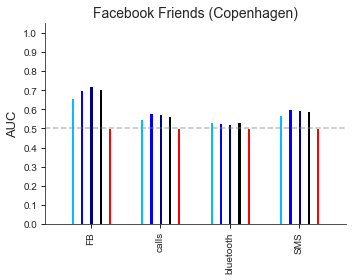

In [20]:
test_type_names = ['FB','calls', 'bluetooth',  'SMS']



from matplotlib.backends.backend_pdf import PdfPages

alpha_empirical = 0.4

%matplotlib inline
f, (ax1) = plt.subplots(1, 1, 
                             sharey=False, sharex=False,
                            figsize=(5, 4))
plt.setp(ax1, xticks=[ 0. ,  1.5,  3. ,  4.5], 
         xticklabels=test_type_names)
plt.setp(ax1.get_xticklabels(), rotation=90, size = 10)

ax1.minorticks_on()
ax1.tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


w = 1.5
width = 0.07
ax1.bar(np.array(range(len(baseline)))*w+0.4,baseline, color = 'red', #alpha = 0.5,
        #align = 'right',
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(auc_record_results[0])))*w-0.4,auc_record_results[0], color = 'deepskyblue',# alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(auc_record_results[1])))*w-0.2,auc_record_results[1], color = 'blue', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(auc_record_results[2])))*w-0,auc_record_results[2], color = 'darkblue', #alpha = 0.5,
       width = width, edgecolor = 'white')

ax1.bar(np.array(range(len(auc_record_results[3])))*w+0.2,auc_record_results[3], color = 'black', #alpha = 0.5,
       # align = 'center',
       width = width, edgecolor = 'white')
ax1.set_ylabel('AUC', size=13)

ax1.set_xlim(-1,np.max(np.array(range(len(auc_record)))*w)+1)
#ax1.set_xlim(-1,18.5)

ax1.set_ylim(0,1.05)
plt.yticks(np.arange(0,1.1,0.1))
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)



ax1.set_title('Facebook Friends (Copenhagen)', size = 14)
plt.tight_layout()
if undersampling:
    if RF:
        pp = PdfPages('../figs/NEWundersampleRF_' + train_subset_type + '.pdf') 
    else:
        pp = PdfPages('../figs/NEWundersampleLogForest_' + train_subset_type + '.pdf' ) 
else:
    if RF:
        pp = PdfPages('../figs/NEWRF_' + train_subset_type + '.pdf') 
    else:
        pp = PdfPages('../figs/NEWLogForest_' + train_subset_type + '.pdf' ) 
pp.savefig(pad_inches=1 ) 
pp.close()

## Paper Figures Within-Network
Compare LINK and ReFeX features as part of a Within-Network Task on the Facebook friends network of Copenhagen.


In [21]:
n_iter = 25

In [26]:
x1 = pd.read_csv('../../code/refex-rolx-master-1/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
print(x1.head())
df_train = pd.DataFrame({'keys':np.array(x1[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
x1 = x1.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


x1 = x1.loc[:,1::] #drop IDs column
scaler.fit(x1) #transform each feature on [0,1]-scale
x1 = scaler.transform(x1)

y1 = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

     0    1    2    3    4    5    6
0  338  0.0  2.0  1.0  1.0  1.0  2.0
1  339  0.0  2.0  1.0  2.0  1.0  2.0
2  332  0.0  1.0  1.0  1.0  1.0  1.0
3  333  0.0  3.0  1.0  2.0  1.0  3.0
4  330  0.0  4.0  1.0  4.0  1.0  3.0


In [27]:
x2 = pd.read_csv('../../code/refex-rolx-master-2/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
df_train = pd.DataFrame({'keys':np.array(x2[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
x2 = x2.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


x2 = x2.loc[:,1::] #drop IDs column
scaler.fit(x2) #transform each feature on [0,1]-scale
x2 = scaler.transform(x2)

y2 = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

In [28]:
x3 = pd.read_csv('../../code/refex-rolx-master-3/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
df_train = pd.DataFrame({'keys':np.array(x3[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
x3 = x3.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


x3 = x3.loc[:,1::] #drop IDs column
scaler.fit(x3) #transform each feature on [0,1]-scale
x3 = scaler.transform(x3)

y3 = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

In [29]:
xall = pd.read_csv('../../code/refex-rolx-master/'+ 
                    '/Copenhagen-data/out_union_0.5_Copenhagen_df_facebook_friends_undirected.csv-featureValues.csv',
                     header = None)
df_train = pd.DataFrame({'keys':np.array(xall[0])})
y_train_y = pd.read_csv('../../data/CopenhagenNW/genders.csv')
y_train_y.columns = ['keys','gender_y']

ids_train = np.array(df_train['keys'])[np.in1d(np.array(df_train['keys']), np.array(y_train_y['keys']))]
xall = xall.iloc[np.in1d(df_train['keys'], ids_train)]
df_train = df_train.iloc[np.in1d(df_train['keys'], ids_train)]


xall = xall.loc[:,1::] #drop IDs column
scaler.fit(xall) #transform each feature on [0,1]-scale
xall = scaler.transform(xall)

yall = df_train.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')

In [30]:
RF = True # else continues using LogForest models from earlier
undersampling = False

if RF:
    if undersampling:
        ## add in -- undersampling possibly
        max_depth = [3, 5, 10]
        max_depth.append(None)
        min_samples_leaf = [0.05, 0.1, 0.2]
        min_samples_split = [2, 3, 4, 5, 10]
        n_estimators = [50, 100, 150] #[10, 50, 100, 150, 200]
        max_features = ['auto', 0.25, 0.5, 0.75]
        random_grid = {'clf__max_depth': max_depth,
                     'clf__min_samples_leaf': min_samples_leaf,
                     'clf__max_features': max_features,
                      'clf__n_estimators': n_estimators,
                      'clf__min_samples_split': min_samples_split
        }

        clf = sklearn.ensemble.RandomForestClassifier()
        pipeline = imbPipeline([('undersample', imblearn.under_sampling.RandomUnderSampler(random_state=567)),
                                    #('oversample',imblearn.over_sampling.SMOTE()), 
                            ('clf',clf)])
        model1 = RandomizedSearchCV(estimator = pipeline,
                param_distributions = random_grid,
                cv = 3, verbose=0,
                n_jobs = 2)

        model2 = RandomizedSearchCV(estimator = pipeline,
                param_distributions = random_grid,
                cv = 3, verbose=0,
                n_jobs = 2)

        model3 = RandomizedSearchCV(estimator = pipeline,
                param_distributions = random_grid,
                cv = 3, verbose=0,
                n_jobs = 2)

        modelall = RandomizedSearchCV(estimator = pipeline,
                param_distributions = random_grid,
                cv = 3, verbose=0,
                n_jobs = 2)
    else:
        max_depth = [3, 5, 10]
        max_depth.append(None)
        min_samples_leaf = [1]#[0.05, 0.1, 0.2]
        min_samples_split = [2,5] #[2, 3, 4, 5, 10]
        n_estimators = [100, 1000]#150]
        max_features = ['auto', 0.25, 0.5, 0.75]
        random_grid = {'max_depth': max_depth,
                        'min_samples_leaf': min_samples_leaf,
                        'max_features': max_features,
                        'n_estimators': n_estimators,
                        'min_samples_split': min_samples_split,
                       'class_weight': [{1:0.505, 1:50.5},{1:0.51, 1:25.5},{1:0.525, 1:10.5},{1:0.55, 1:5.5},{1:0.7, 1:1.75}]
                        }

        clf = sklearn.ensemble.RandomForestClassifier()
        model1 = RandomizedSearchCV(estimator = clf,
                                   param_distributions = random_grid, n_iter=25, 
                                   cv = 3, verbose=0,
                                   n_jobs = 4)

        model2 = RandomizedSearchCV(estimator = clf,
                                    param_distributions = random_grid,n_iter=25, 
                                    cv = 3, verbose=0,
                                    n_jobs = 4)
        model3 = RandomizedSearchCV(estimator = clf,
                                    param_distributions = random_grid,n_iter=25, 
                                    cv = 3, verbose=0,
                                    n_jobs = 4)
        modelall = RandomizedSearchCV(estimator = clf,
                                    param_distributions = random_grid,n_iter=25, 
                                    cv = 3, verbose=0,
                                    n_jobs = 4)

In [31]:
percent_initially_unlabelled = [0.95,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
percent_initially_labelled = np.subtract(1, percent_initially_unlabelled)

In [32]:
C_vals = [10**x for x in range(-10,100)]

(mean_accuracy_x1_LR, se_accuracy_x1_LR, 
 mean_micro_auc_x1_LR,se_micro_auc_x1_LR, mean_wt_auc_x1_lbfgs_LR,se_wt_auc_x1_LR)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y1.gender_y), ## gender labels 
                                                              np.matrix(x1), ## adjacency matrix
                                                              clf = linear_model.LogisticRegressionCV(
                                                                       Cs = C_vals,
                                                                       penalty='l2',
                                                                        solver='lbfgs',
                                                                       class_weight='balanced',
                                                                       cv = 5), num_iter=n_iter,
                                                                             cv_setup = 'stratified')



0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [33]:
(mean_accuracy_x1, se_accuracy_x1, 
 mean_micro_auc_x1,se_micro_auc_x1, mean_wt_auc_x1_lbfgs,se_wt_auc_x1)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y1.gender_y), ## gender labels 
                                                              np.matrix(x1), ## adjacency matrix
                                                              clf = model1,num_iter=n_iter,
                                                                             cv_setup = 'stratified')




0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/met

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

In [35]:
(mean_accuracy_x2, se_accuracy_x2, 
 mean_micro_auc_x2, se_micro_auc_x2, mean_wt_auc_x2_lbfgs,se_wt_auc_x2)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y2.gender_y), ## gender labels 
                                                              np.matrix(x2), ## adjacency matrix
                                                              clf = model2,num_iter=n_iter,
                                                                             cv_setup = 'stratified')





0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

In [36]:
(mean_accuracy_x3, se_accuracy_x3, 
 mean_micro_auc_x3, se_micro_auc_x3, mean_wt_auc_x3_lbfgs,se_wt_auc_x3)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(y3.gender_y), ## gender labels 
                                                              np.matrix(x3), ## adjacency matrix
                                                              clf = model3,num_iter=n_iter,
                                                                             cv_setup = 'stratified')






0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

In [37]:
(mean_accuracy_xall, se_accuracy_xall, 
 mean_micro_auc_xall, se_micro_auc_xall, mean_wt_auc_xall_lbfgs,se_wt_auc_xall)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(yall.gender_y), ## gender labels 
                                                              np.matrix(xall), ## adjacency matrix
                                                              clf = modelall,num_iter=n_iter,
                                                                             cv_setup = 'stratified')







0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

## Set-Up for LINK

In [38]:
## undirected
edges = pd.read_csv('../../data/CopenhagenNW/processed_edgelist/df_facebook_friends_undirected.csv',
                   header = None)



print(edges.head())
df = pd.crosstab(edges[0], edges[1])
#print(df.head())
idx = df.columns.union(df.index)
df = df.reindex(index = idx, columns=idx, fill_value=0)
df.head()


   0    1  2
0  0  104  1
1  0  107  1
2  0  108  1
3  0  208  1
4  0  263  1


,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,844,845,846,848,850
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [39]:
# check which nodes are not in gender label dataset
np.mean(~np.in1d(np.unique(np.concatenate((edges[0],edges[1]))),
    np.array(y_train_y['keys'])))

0.06625

In [40]:
nx.number_connected_components(nx.from_numpy_matrix(np.matrix(df)))

1

In [41]:
len(np.unique(np.concatenate((edges[0], edges[1]))))

800

In [42]:
# quick sanity check
node_id = 255
print(np.sum(edges[0]==node_id))
print(np.sum(df,1)[node_id])

4
4


In [43]:
print(edges.head())
edges.columns = ['source','target','link']

   0    1  2
0  0  104  1
1  0  107  1
2  0  108  1
3  0  208  1
4  0  263  1


In [44]:
G = nx.from_pandas_edgelist(edges,source='source', target='target')
print(nx.number_connected_components(G))
print(len(G.nodes()))
#[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
#347/536




1
800


In [45]:
adj_LINK = nx.adjacency_matrix(G).todense()
np.shape(adj_LINK)


(800, 800)

In [46]:
tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp.columns = ['keys']
print(len(tmp))
tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')
print(len(tmp))
np.sum(tmp['keys']!=G.nodes()) # quick check that gender is now in same order as nodes

800
800


0

In [47]:
adj_LINK = adj_LINK[~tmp.gender_y.isna(),:]
#adj_LINK = adj_LINK.T[~tmp.gender_y.isna(),:]


tmp = tmp[~tmp.gender_y.isna()]

In [ ]:
print(np.shape(adj_LINK))
print(np.shape(x1))
print(np.shape(tmp))
print(tmp[0:6])
print(np.array(G.nodes)[0:6])

### add in node degree and compare to ReFex-1

In [49]:
degree_x = np.array(np.sum(adj_LINK,1).T)[0]
len(tmp.gender_y)
print(len(degree_x))

747


In [50]:
(mean_accuracy_degree, se_accuracy_degree, 
 mean_micro_auc_degree,se_micro_auc_degree, mean_wt_degree,se_wt_degree)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(tmp.gender_y).astype(np.int), ## gender labels 
                                                              np.matrix(degree_x).T, ## adjacency matrix
                                                       clf = linear_model.LogisticRegression(penalty='l2',
                                                                        solver='lbfgs',
                                                                        C=10e20,
                                                                       class_weight='balanced'),num_iter=n_iter, 
                                                                     cv_setup = 'stratified')



0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9
0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7
0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4
0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2
0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

## LINK

In [53]:
(mean_accuracy_LINK_RM, se_accuracy_LINK_RM, 
 mean_micro_auc_LINK_RM,se_micro_auc_LINK_RM, mean_wt_LINK_RM,se_wt_LINK_RM)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(tmp.gender_y).astype(np.int), ## gender labels 
                                                              adj_LINK, ## adjacency matrix
                                                       clf = linear_model.LogisticRegression(penalty='l2',
                                                                        solver='lbfgs',
                                                                        C=10e20,
                                                                       class_weight='balanced'),
                                                                                   num_iter=n_iter, 
                                                                     cv_setup = 'stratified')


0.95
0.9
0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1
0.05


### try choosing C via cross-validation

In [54]:
C_vals = [10**x for x in range(-10,100)]

(mean_accuracy_LINK_C, se_accuracy_LINK_C, 
 mean_micro_auc_LINK_C,se_micro_auc_LINK_C, mean_wt_LINK_C,se_wt_LINK_C)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(tmp.gender_y).astype(np.int), ## gender labels 
                                                              adj_LINK, ## adjacency matrix
                                                       clf = linear_model.LogisticRegressionCV(
                                                                       Cs = C_vals,
                                                                       penalty='l2',
                                                                        solver='lbfgs',
                                                                       class_weight='balanced',
                                                                       cv = 5),
                                                                                   num_iter=n_iter, 
                                                                     cv_setup = 'stratified')



0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [55]:
(mean_accuracy_degree_C, se_accuracy_degree_C, 
 mean_micro_auc_degree_C,se_micro_auc_degree_C, mean_wt_degree_C,se_wt_degree_C)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(tmp.gender_y).astype(np.int), ## gender labels 
                                                              np.matrix(degree_x).T, ## adjacency matrix
                                                        clf = linear_model.LogisticRegressionCV(
                                                                       Cs = C_vals,
                                                                       penalty='l2',
                                                                        solver='lbfgs',
                                                                       class_weight='balanced',
                                                                       cv = 5),
                                                                                   num_iter=n_iter, 
                                                                     cv_setup = 'stratified')



0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.2


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.1


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

0.05


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kristen/anaco

In [56]:
tmp = pd.DataFrame(np.array(G.nodes())) # note ordering of adjacency matrix is produced by G.nodes()
tmp.columns = ['keys']
tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')
np.sum(tmp['keys']!=G.nodes()) # quick check that gender is now in same order as nodes

0

### node2vec

In [57]:
node2vec = pd.read_csv('../node2vec/emb/Copenhagen_FB_friends_undirected.emb',
                      skiprows=1,
                       header = None,
                      sep=' ')
node2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,485,0.002486,-0.053928,0.134527,0.030945,-0.081040,0.278858,0.068900,0.269129,-0.000760,...,0.225196,0.103617,0.183940,-0.147103,0.063253,-0.240692,0.090021,0.073122,-0.116765,0.124831
1,706,-0.097825,-0.115843,-0.072174,0.051744,0.001883,-0.015180,0.047926,0.226961,0.269710,...,-0.098098,-0.031725,0.042821,-0.086907,0.291903,-0.179763,-0.122235,-0.138891,0.014209,0.158083
2,13,-0.144620,0.180271,-0.118550,-0.084834,-0.133971,0.154139,0.146713,0.161844,0.012290,...,0.047397,-0.143002,0.129195,0.120592,0.198431,-0.219767,0.002213,-0.119596,-0.018366,0.145404
3,838,-0.268329,-0.118139,0.194004,-0.252774,-0.008776,-0.094214,-0.083010,0.317001,0.166538,...,0.052445,0.189873,-0.078442,-0.023594,0.235831,-0.009959,-0.008357,-0.037030,-0.051390,0.217504
4,324,-0.009168,-0.056394,0.127355,-0.208019,-0.206034,0.227263,0.092271,0.030133,0.312468,...,0.001212,-0.103032,0.127436,-0.131513,0.267709,-0.140657,0.162699,-0.217827,0.098445,0.050885


In [58]:
tmp = pd.DataFrame(node2vec[0])
tmp.columns = ['keys']
tmp = tmp.merge(y_train_y[['keys','gender_y']],
        how = 'left',
        on = 'keys')
tmp.head()


,keys,gender_y
0,485,0.0
1,706,0.0
2,13,0.0
3,838,0.0
4,324,0.0


In [59]:
node2vec.drop(0, axis =1, inplace = True)

In [60]:
## Random Forest Model
(mean_accuracy_node2vec_C, se_accuracy_node2vec_C, 
 mean_micro_auc_node2vec_C,se_micro_auc_node2vec_C, mean_wt_node2vec_C,se_wt_node2vec_C)= LINK(percent_initially_unlabelled, ## note: mean_se_model assumes a vector of x% initially labeled
                                                              np.array(tmp.gender_y).astype(np.int), ## gender labels 
                                                              np.matrix(node2vec), ## adjacency matrix
                                                       clf = modelall,
                                                                                   num_iter=n_iter, 
                                                                     cv_setup = 'stratified')




0.95


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.9


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.8


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.7


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.6


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.5


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.4


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.3


/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/kristen/anaconda3/lib/python3.6/site-packages/sklearn/mod

0.2


KeyboardInterrupt: 

In [67]:
t = pd.read_csv('../../data/CopenhagenNW/finalCopenhagen.csv')
t.head()

,Unnamed: 0,mean_wt_node2vec_C,se_wt_node2vec_C
0,0,0.555006,0.039488
1,1,0.592668,0.023447
2,2,0.627242,0.026713
3,3,0.647644,0.021515
4,4,0.653936,0.025199


In [61]:
from matplotlib.backends.backend_pdf import PdfPages



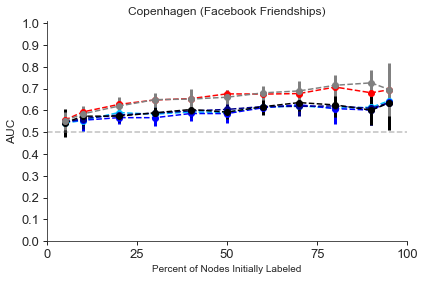

In [73]:
%matplotlib inline
from matplotlib.ticker import FixedLocator,LinearLocator,MultipleLocator, FormatStrFormatter

fig = plt.figure()
seaborn.set_style(style='white')
from mpl_toolkits.axes_grid1 import Grid
grid = Grid(fig, rect=111, nrows_ncols=(1,1),
            axes_pad=0.1, label_mode='L')
for i in range(4):
    if i == 0:
        grid[i].xaxis.set_major_locator(FixedLocator([0,25,50,75,100]))
        grid[i].yaxis.set_major_locator(FixedLocator([0.4, 0.5,0.6,0.7,0.8,0.9,1]))
        grid[i].errorbar(percent_initially_labelled*100, t.mean_wt_node2vec_C,
            yerr=t.se_wt_node2vec_C, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='red')
            
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_x1_lbfgs,
            yerr=se_wt_auc_x1, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='deepskyblue')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_x2_lbfgs,
            yerr=se_wt_auc_x2, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='blue')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_x3_lbfgs,
            yerr=se_wt_auc_x3, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='darkblue')
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_auc_xall_lbfgs,
            yerr=se_wt_auc_xall, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='black')
         
        grid[i].errorbar(percent_initially_labelled*100, mean_wt_LINK_C,#mean_wt_LINK_RM,
            yerr=se_wt_LINK_C, fmt='--o', capthick=2,
            alpha=1, elinewidth=3, color='gray')

            

            
    
            
         
        grid[i].set_ylim(0.3,1.1)
        grid[i].set_xlim(0,101)
        xadd = 0.02




        grid[i].set_ylim(0.25,1.01)
        grid[i].set_xlim(0,100)
        grid[i].spines['right'].set_visible(False)
        grid[i].spines['top'].set_visible(False)
        grid[i].tick_params(axis='both', which='major', labelsize=13)
        grid[i].tick_params(axis='both', which='minor', labelsize=13)
        grid[i].set_xlabel('Percent of Nodes Initially Labeled')
        grid[i].set_ylabel('AUC',fontsize=12)
plt.title('Copenhagen (Facebook Friendships)',fontsize=12)
plt.axhline(0.5, color='gray', linestyle='--', alpha = 0.5)


plt.tight_layout()
grid[0].set_xticks([0,25, 50, 75, 100])
grid[0].set_yticks([0,0.1,0.2,0.3, 0.4, 0.5,0.6,0.7,0.8,0.9,1])
grid[0].minorticks_on()
grid[0].tick_params('both', length=4, width=1, which='major', left=1, bottom=1, top=0, right=0)
if RF:
    if undersampling:
            pp = PdfPages('..figs/NEWwithin_Copenhagen_auc_RF_undersampling.pdf')
    else:
            pp = PdfPages('../figs/NEWwithin_Copenhagen_auc_RF_costbased.pdf')
else:
    pp = PdfPages('../figs/NEWwithin_Copenhagen_auc.pdf')
pp.savefig()
pp.close()